## Goal

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve it.

---

## Challenge Description


We have data about all users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:

- Predict conversion rate

- Come up with recommendations for the product team and the marketing team to improve conversion rate

## Descriptive Stats

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

In [3]:
#read from google drive
data = pd.read_csv('/Users/Celia/work_venv/conversion_project.csv')
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


- country : user country based on the IP address

- age : user age. Self-reported at sign-up step

- new_user : whether the user created the account during this session or had already an account and simply came back to the site

- source : marketing channel source
    - Ads: came to the site by clicking on an advertisement
    - Seo: came to the site by clicking on search results
- Direct: came to the site by directly typing the URL on the browser

- total_pages_visited: number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement

- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions

In [3]:
print(data.describe())

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


In [4]:
print(data.groupby(['country']).size())

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64


In [5]:
print(data.groupby(['source']).size())

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


A few quick observations:

- the site is probably a US site, although it does have a large Chinese user base as well

- user base is pretty young

- conversion rate at around 3% is industry standard. It makes sense

- everything seems to make sense here except for max age 123 yrs! Let’s investigate it:

In [6]:
print(sorted(data['age'].unique(), reverse=True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


Those 123 and 111 values seem unrealistic. How many users are we talking about:

In [5]:
print(data[data['age']>110])

        country  age  new_user source  total_pages_visited  converted
90928   Germany  123         0    Seo                   15          1
295581       UK  111         0    Ads                   10          1


It is just 2 users! In this case, we can remove them, nothing will change. In general, depending on the problem, you can:

- remove the entire row saying you don’t trust the data

- treat them as NAs

- if there is a pattern, try to figure out what went wrong.

That being said, wrong data is worrisome and can be an indicator of some bug in the logging code. Therefore, when working, you will want to talk to the software engineer who implemented the logging code to see if, perhaps, there are some bugs which affect the data significantly.

Here, let’s just get rid of those two rows:

In [4]:
data = data[data['age']<110]

Now, let’s quickly investigate the variables and how their distribution differs for the two classes. This will help us understand whether there is any information in our data in the first place and get a sense of the data.

Never start by blindly building a machine learning model. Always first get a sense of the data

Let’s just pick a couple of variables as example, but you should do it with all:

In [5]:
import matplotlib.pyplot as plt

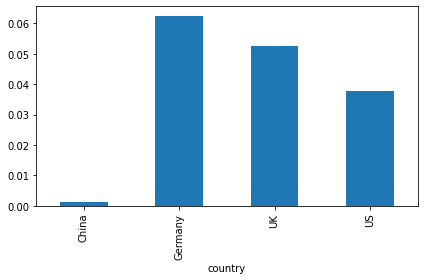

In [6]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
  
data.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

Here it clearly looks like Chinese convert at a much lower rate than other countries!

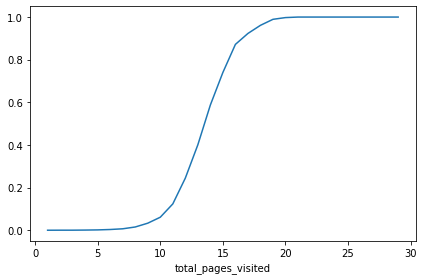

In [8]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

Definitely spending more time on the site implies higher probability of conversion!

## Machine Learning


Let’s now build a model to predict conversion rate. Outcome is binary and you care about insights to give product and marketing team project ideas. You should probably choose among the following options:

- Logistic regression

- Decision Trees

- RuleFit

- Random Forest or Boosted Decision Trees in combination with partial dependence plots

It is good to add two lines to explain why you chose a given approach.

Ex: I am going to pick a random forest to predict conversion rate. I picked a random forest because: it usually requires very little time to optimize it (its default params are often close to be the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict conversion, then I will use its partial dependence plots and variable importance to get insights. Also, I will build a simple tree to find the most obvious user segments.

Firstly, let’s create dummy variables from the categorical ones:

In [7]:
#dummy variables for the categorical ones
data_dummy = pd.get_dummies(data, drop_first=True)

Create test/training set with a standard 66% split (if the data were too small, I would cross-validate). Then, I build the forest with standard values for the 3 important parameters (100 trees, trees as large as possible, 3 random variables selected at each split).

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)

In [10]:
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)


OOB accuracy is 0.9838851885571901 
 OOB Confusion Matrix 
         0     1
0  200872  1102
1    2261  4455


\* The out-of-bag (OOB) error is the average error for each  calculated using predictions from the trees that do not contain  in their respective bootstrap sample. This allows the RandomForestClassifier to be fit and validated whilst being trained

In [11]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


So, OOB error and test error are pretty similar, ~1.5%. We are confident we are not overfitting.

Error is pretty low. However, we started from a 97% accuracy (that’s the case if we classified everything as a “non converted”). So, 98.5% is good, but nothing shocking. Indeed, ~30% of conversions are predicted as “non conversion”.

If we cared about the very best possible accuracy or specifically minimizing false positive/false negative, we would find the best cut-off point. Since in this case that doesn’t appear to be particularly relevant, we are fine with the default 0.5 cutoff value used internally by the random forest to make the prediction.

If you care about insights, building a model is just the first step. You need to check that the model predicts well and, if it does, you can now extract insights out of it.

Let’s start by checking variable importance:

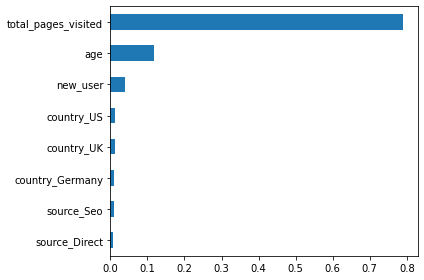

In [12]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages because they already want to buy. Also, in order to buy, you have to click on multiple pages. Let’s rebuild the RF without that variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weights, just to make sure we will get something classified as 1.

In [13]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978


In [14]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)


Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


Accuracy went down, but that’s fine. The model is still good enough to give us insights.

Let’s recheck variable importance:

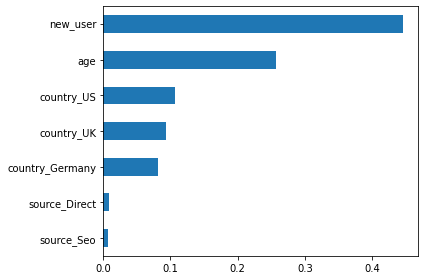

In [15]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Interesting! New user is the most important one, even more important than age. And that’s impressive given that continuous variables tend to always show up at the top in RF variable importance plots. It means new_user is really important. Source-related dummies don’t seem to matter at all.



<p>Let’s check <b>partial dependence plots</b> for the 4 vars:</p>
<p> The partial dependence plot (short PDP or PD plot) shows the  marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 200130). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. </p>

<p>The partial dependence function for regression is defined as:</p>
$$\hat{f}_S(x_S)=E_{X_C}\left[\hat{f}(x_S,X_C)\right]=\int\hat{f}(x_S,X_C)d\mathbb{P}(X_C)$$
<p>The $x_S$ are the features for which the partial dependence function should be plotted and $X_C$ are the other features used in the machine learning model $\hat{f}$, which are here treated as random variables. <br>
Usually, there are only one or two features in the set $S$. The feature(s) in $S$ are those for which we want to know the effect on the prediction.</p>

In [16]:
from pdpbox import pdp, info_plots

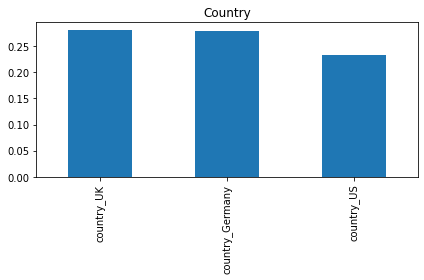

In [17]:
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

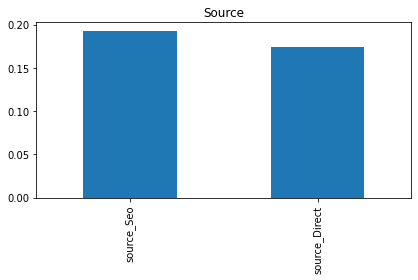

In [18]:
#source
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

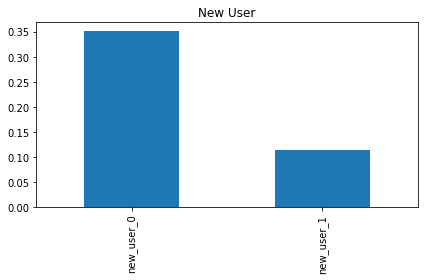

In [19]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

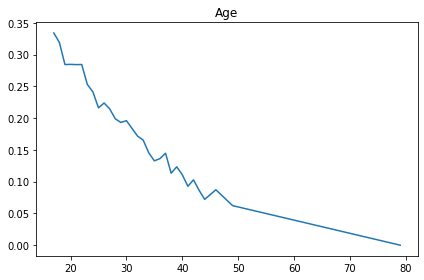

In [20]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

This shows that:

- Users with an old account are much better than new users

- Germany, UK, and US are similar, with Germany being the best. Most importantly, they all have very very high values. We could read this as relative to the reference level, which is China. So this means that not being from China and being from any of those 3 countries significantly increases the probability of conversion. That is, China is very bad for conversion

- The site works very well for young people and gets worse for >30 yr old

- Source is less relevant

Let’s now build a simple decision tree and check the 2 or 3 most important segments:


In [22]:
import graphviz
from graphviz import Source

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [25]:
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=2,
                       min_impurity_decrease=0.001)

In [27]:
#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_conversion.dot")
s.view()


'tree_conversion.dot.pdf'

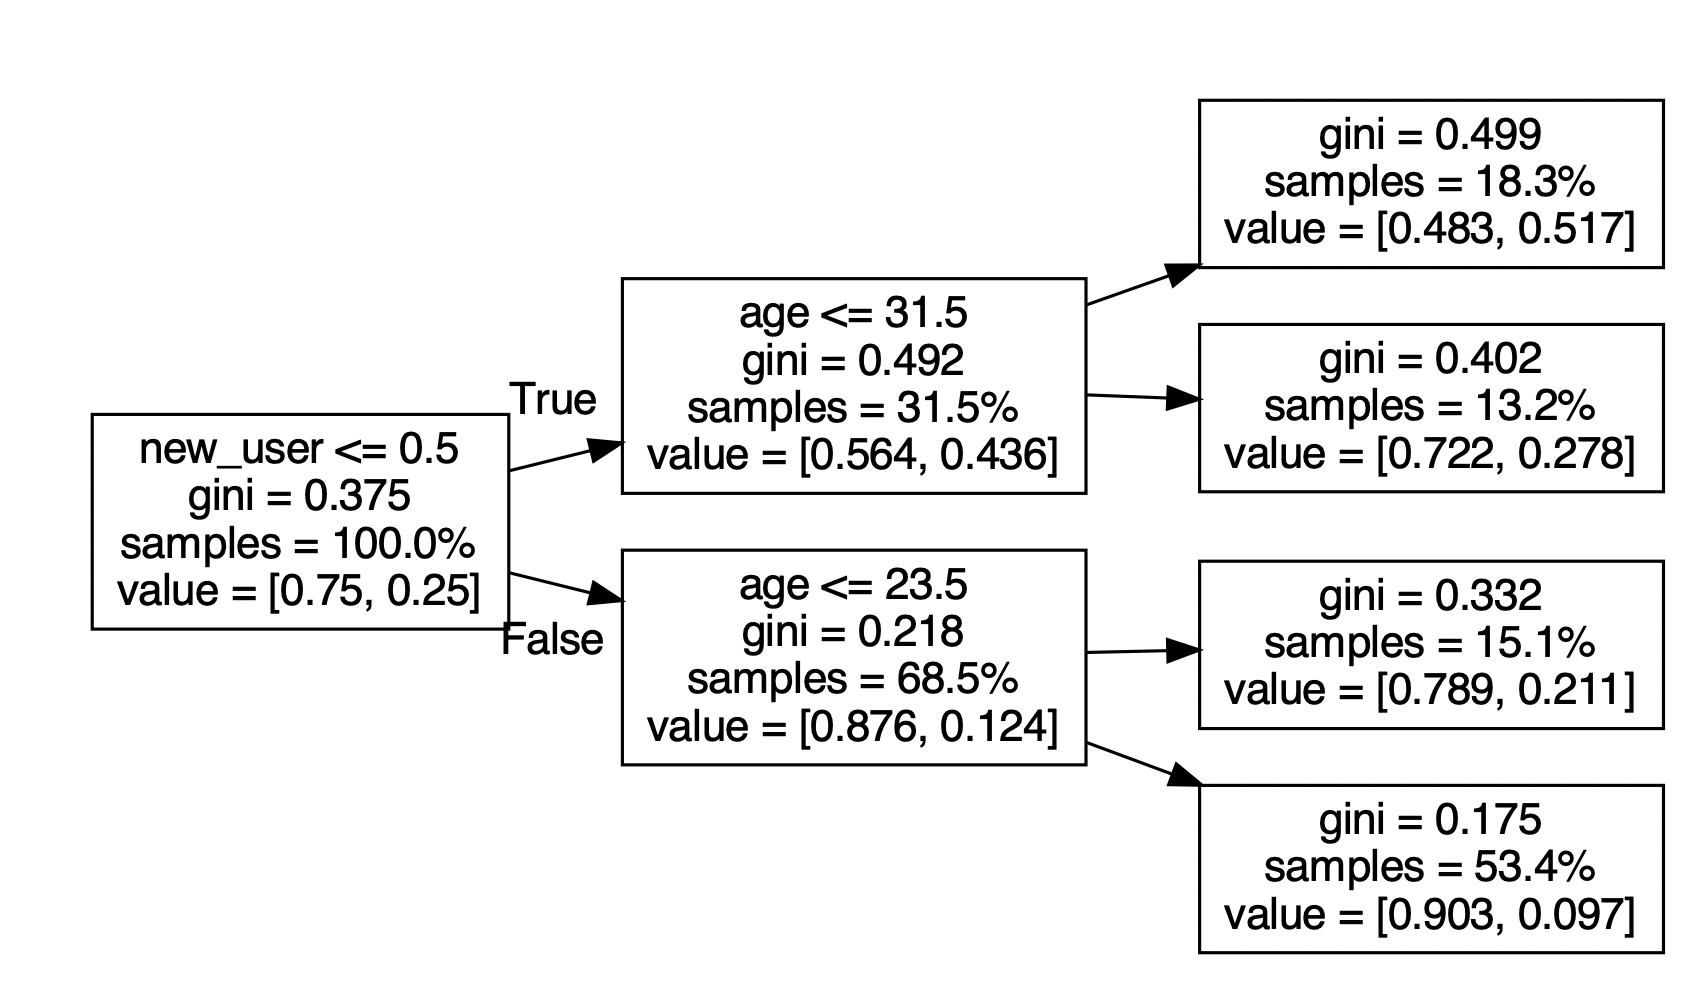

## Conclusions and next steps:




1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

2. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

4. Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

5. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.


As you can see, product ideas usually end up being about:

- Identify segments that perform well, but have low absolute count (like Germany). Then tell marketing to get more of those people

- Tell product to fix the experience for the bad performing ones

- Bad performing segments with high absolute count (like China) usually provide the biggest opportunities for massive gains, if you can guess why that’s happening and then build a test to validate your hypothesis